In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


1/1 [==============================] - 2s 2s/step
Epoch 1/100, Batch 1/25, Discriminator Loss: 0.9807332158088684, Generator Loss: 0.44417804479599
1/1 [==============================] - 0s 22ms/step
Epoch 1/100, Batch 2/25, Discriminator Loss: 3.207776188850403, Generator Loss: 0.46566545963287354
1/1 [==============================] - 0s 28ms/step
Epoch 1/100, Batch 3/25, Discriminator Loss: 3.100050926208496, Generator Loss: 0.40666553378105164
1/1 [==============================] - 0s 33ms/step
Epoch 1/100, Batch 4/25, Discriminator Loss: 2.3016862869262695, Generator Loss: 0.3738222122192383
1/1 [==============================] - 0s 25ms/step
Epoch 1/100, Batch 5/25, Discriminator Loss: 1.7614099979400635, Generator Loss: 0.36170199513435364
1/1 [==============================] - 0s 23ms/step
Epoch 1/100, Batch 6/25, Discriminator Loss: 1.4063615202903748, Generator Loss: 0.290530800819397
1/1 [==============================] - 0s 25ms/step
Epoch 1/100, Batch 7/25, Discriminator L

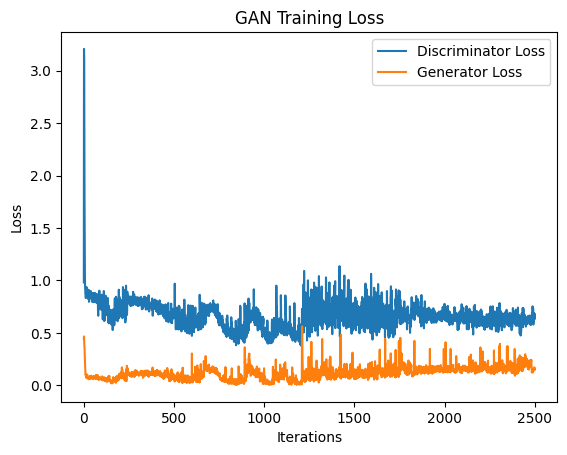

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 341ms/step


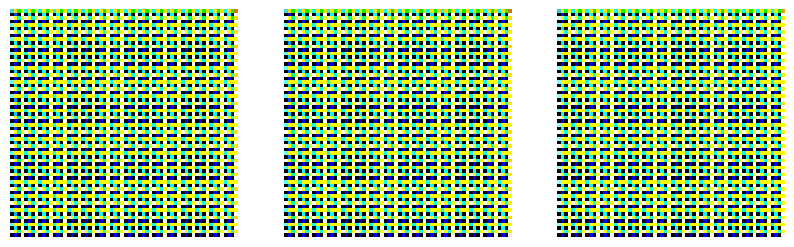

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from PIL import Image
import io

df = pd.read_parquet('/content/drive/MyDrive/train-00000-of-00001-b64601da56687a05.parquet')
shortened_df = df.head(800)
noise_dim = 100
epochs = 100
batch_size = 32
label_smoothing = 0.1

def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes['bytes']))
    image = image.convert('RGB')
    image = image.resize((64, 64))
    image = np.array(image)
    image = image.astype(np.float32) / 255.0
    return image

images = np.array([preprocess_image(image) for image in shortened_df['image']])

def build_generator(noise_dim):
    input_noise = layers.Input(shape=(noise_dim,))
    noise_dense = layers.Dense(256)(input_noise)
    noise_dense = layers.BatchNormalization()(noise_dense)
    noise_dense = layers.LeakyReLU(0.2)(noise_dense)
    x = layers.Dense(256 * 8 * 8)(noise_dense)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    generator_output = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)
    generator_model = models.Model(inputs=[input_noise], outputs=generator_output)
    return generator_model

def build_discriminator():
    input_image = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    image_embedding = layers.Flatten()(x)
    x = layers.Dense(256)(image_embedding)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    discriminator_output = layers.Dense(1, activation='sigmoid')(x)
    discriminator_model = models.Model(inputs=[input_image], outputs=discriminator_output)
    return discriminator_model

def build_gan(generator, discriminator):
    input_noise = layers.Input(shape=(noise_dim,))
    fake_image = generator([input_noise])
    validity = discriminator([fake_image])
    gan = models.Model(inputs=[input_noise], outputs=validity)
    return gan

generator = build_generator(noise_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer='adam', loss='mse')

import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, images, noise_dim, epochs=10, batch_size=32):
    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        for batch_start in range(0, len(images), batch_size):
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            real_images_batch = images[batch_start:batch_start+batch_size]
            generated_images = generator.predict([noise])

            discriminator_loss_real = discriminator.train_on_batch([real_images_batch], np.ones((batch_size, 1)) * (1 - label_smoothing))
            discriminator_loss_fake = discriminator.train_on_batch([generated_images], np.zeros((batch_size, 1)) + label_smoothing)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gan_loss = gan.train_on_batch([noise], np.ones((batch_size, 1)))

            discriminator_losses.append(discriminator_loss[0])
            generator_losses.append(gan_loss)

            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{len(images)//batch_size}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {gan_loss}")

    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.plot(generator_losses, label='Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.savefig('loss_plot.pdf')
    plt.show()

    generator.save('generator_model_rr_50.h5')

    sample_noise = np.random.normal(0, 1, (3, noise_dim))
    generated_samples = generator.predict(sample_noise)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(generated_samples[i])
        ax.axis('off')
    plt.savefig('sample_images.pdf')
    plt.show()

train_gan(generator, discriminator, gan, images, noise_dim, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 32ms/step
Epoch 201/300, Batch 1/25, Discriminator Loss: 0.5588273108005524, Generator Loss: 0.18606367707252502
1/1 [==============================] - 0s 24ms/step
Epoch 201/300, Batch 2/25, Discriminator Loss: 0.5412295758724213, Generator Loss: 0.20288929343223572
1/1 [==============================] - 0s 25ms/step
Epoch 201/300, Batch 3/25, Discriminator Loss: 0.6102166175842285, Generator Loss: 0.19136258959770203
1/1 [==============================] - 0s 36ms/step
Epoch 201/300, Batch 4/25, Discriminator Loss: 0.6182529032230377, Generator Loss: 0.23268523812294006
1/1 [==============================] - 0s 26ms/step
Epoch 201/300, Batch 5/25, Discriminator Loss: 0.6333247721195221, Generator Loss: 0.21157029271125793
1/1 [==============================] - 0s 28ms/step
Epoch 201/300, Batch 6/25, Discriminator Loss: 0.6101681292057037, Generator Loss: 0.18408548831939697
1/1 [==============

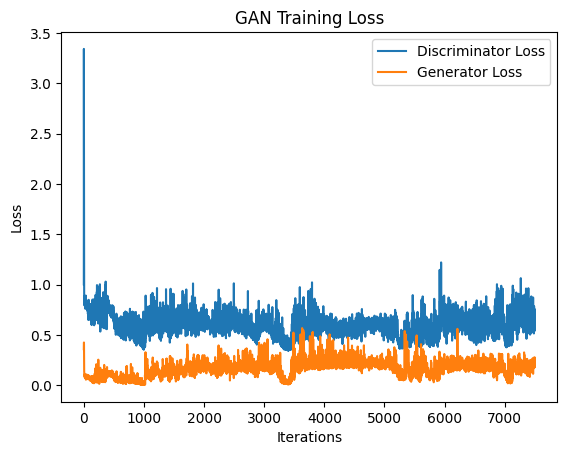

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 244ms/step


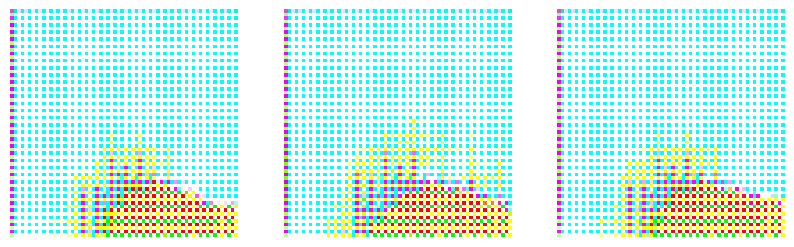

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from PIL import Image
import io

df = pd.read_parquet('/content/drive/MyDrive/train-00000-of-00001-b64601da56687a05.parquet')
shortened_df = df.head(800)
noise_dim = 100
epochs = 300
batch_size = 32
label_smoothing = 0.1

def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes['bytes']))
    image = image.convert('RGB')
    image = image.resize((64, 64))
    image = np.array(image)
    image = image.astype(np.float32) / 255.0
    return image

images = np.array([preprocess_image(image) for image in shortened_df['image']])

def build_generator(noise_dim):
    input_noise = layers.Input(shape=(noise_dim,))
    noise_dense = layers.Dense(256)(input_noise)
    noise_dense = layers.BatchNormalization()(noise_dense)
    noise_dense = layers.LeakyReLU(0.2)(noise_dense)
    x = layers.Dense(256 * 8 * 8)(noise_dense)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    generator_output = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)
    generator_model = models.Model(inputs=[input_noise], outputs=generator_output)
    return generator_model

def build_discriminator():
    input_image = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    image_embedding = layers.Flatten()(x)
    x = layers.Dense(256)(image_embedding)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    discriminator_output = layers.Dense(1, activation='sigmoid')(x)
    discriminator_model = models.Model(inputs=[input_image], outputs=discriminator_output)
    return discriminator_model

def build_gan(generator, discriminator):
    input_noise = layers.Input(shape=(noise_dim,))
    fake_image = generator([input_noise])
    validity = discriminator([fake_image])
    gan = models.Model(inputs=[input_noise], outputs=validity)
    return gan

generator = build_generator(noise_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer='adam', loss='mse')

import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, images, noise_dim, epochs=10, batch_size=32):
    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        for batch_start in range(0, len(images), batch_size):
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            real_images_batch = images[batch_start:batch_start+batch_size]
            generated_images = generator.predict([noise])

            discriminator_loss_real = discriminator.train_on_batch([real_images_batch], np.ones((batch_size, 1)) * (1 - label_smoothing))
            discriminator_loss_fake = discriminator.train_on_batch([generated_images], np.zeros((batch_size, 1)) + label_smoothing)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gan_loss = gan.train_on_batch([noise], np.ones((batch_size, 1)))

            discriminator_losses.append(discriminator_loss[0])
            generator_losses.append(gan_loss)

            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{len(images)//batch_size}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {gan_loss}")

    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.plot(generator_losses, label='Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.savefig('loss_plot.pdf')
    plt.show()

    generator.save('generator_model_rr_50.h5')

    sample_noise = np.random.normal(0, 1, (3, noise_dim))
    generated_samples = generator.predict(sample_noise)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(generated_samples[i])
        ax.axis('off')
    plt.savefig('sample_images.pdf')
    plt.show()

train_gan(generator, discriminator, gan, images, noise_dim, epochs, batch_size)

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
from PIL import Image
import io

df = pd.read_parquet('/content/drive/MyDrive/train-00000-of-00001-b64601da56687a05.parquet')
shortened_df = df.head(800)
noise_dim = 100
epochs = 500
batch_size = 32
label_smoothing = 0.1

def preprocess_image(image_bytes):
    image = Image.open(io.BytesIO(image_bytes['bytes']))
    image = image.convert('RGB')
    image = image.resize((64, 64))
    image = np.array(image)
    image = image.astype(np.float32) / 255.0
    return image

images = np.array([preprocess_image(image) for image in shortened_df['image']])

def build_generator(noise_dim):
    input_noise = layers.Input(shape=(noise_dim,))
    noise_dense = layers.Dense(256)(input_noise)
    noise_dense = layers.BatchNormalization()(noise_dense)
    noise_dense = layers.LeakyReLU(0.2)(noise_dense)
    x = layers.Dense(256 * 8 * 8)(noise_dense)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((8, 8, 256))(x)
    x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    generator_output = layers.Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)
    generator_model = models.Model(inputs=[input_noise], outputs=generator_output)
    return generator_model

def build_discriminator():
    input_image = layers.Input(shape=(64, 64, 3))
    x = layers.Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    image_embedding = layers.Flatten()(x)
    x = layers.Dense(256)(image_embedding)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.2)(x)
    discriminator_output = layers.Dense(1, activation='sigmoid')(x)
    discriminator_model = models.Model(inputs=[input_image], outputs=discriminator_output)
    return discriminator_model

def build_gan(generator, discriminator):
    input_noise = layers.Input(shape=(noise_dim,))
    fake_image = generator([input_noise])
    validity = discriminator([fake_image])
    gan = models.Model(inputs=[input_noise], outputs=validity)
    return gan

generator = build_generator(noise_dim)
discriminator = build_discriminator()
gan = build_gan(generator, discriminator)

discriminator.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gan.compile(optimizer='adam', loss='mse')

import matplotlib.pyplot as plt

def train_gan(generator, discriminator, gan, images, noise_dim, epochs=10, batch_size=32):
    discriminator_losses = []
    generator_losses = []

    for epoch in range(epochs):
        for batch_start in range(0, len(images), batch_size):
            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            real_images_batch = images[batch_start:batch_start+batch_size]
            generated_images = generator.predict([noise])

            discriminator_loss_real = discriminator.train_on_batch([real_images_batch], np.ones((batch_size, 1)) * (1 - label_smoothing))
            discriminator_loss_fake = discriminator.train_on_batch([generated_images], np.zeros((batch_size, 1)) + label_smoothing)
            discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)

            noise = np.random.normal(0, 1, (batch_size, noise_dim))
            gan_loss = gan.train_on_batch([noise], np.ones((batch_size, 1)))

            discriminator_losses.append(discriminator_loss[0])
            generator_losses.append(gan_loss)

            print(f"Epoch {epoch+1}/{epochs}, Batch {batch_start//batch_size+1}/{len(images)//batch_size}, Discriminator Loss: {discriminator_loss[0]}, Generator Loss: {gan_loss}")

    plt.plot(discriminator_losses, label='Discriminator Loss')
    plt.plot(generator_losses, label='Generator Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('GAN Training Loss')
    plt.legend()
    plt.savefig('loss_plot.pdf')
    plt.show()

    generator.save('generator_model_rr_500.h5')

    sample_noise = np.random.normal(0, 1, (3, noise_dim))
    generated_samples = generator.predict(sample_noise)

    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    for i, ax in enumerate(axes):
        ax.imshow(generated_samples[i])
        ax.axis('off')
    plt.savefig('sample_images.pdf')
    plt.show()

train_gan(generator, discriminator, gan, images, noise_dim, epochs, batch_size)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 237ms/step
Epoch 21/500, Batch 15/25, Discriminator Loss: 0.6855515837669373, Generator Loss: 0.12125420570373535
1/1 [==============================] - 0s 208ms/step
Epoch 21/500, Batch 16/25, Discriminator Loss: 0.6515179723501205, Generator Loss: 0.15312282741069794
1/1 [==============================] - 0s 363ms/step
Epoch 21/500, Batch 17/25, Discriminator Loss: 0.6265366971492767, Generator Loss: 0.11857438087463379
1/1 [==============================] - 0s 223ms/step
Epoch 21/500, Batch 18/25, Discriminator Loss: 0.769978404045105, Generator Loss: 0.1527659296989441
1/1 [==============================] - 0s 226ms/step
Epoch 21/500, Batch 19/25, Discriminator Loss: 0.7578685283660889, Generator Loss: 0.1610933393239975
1/1 [==============================] - 0s 223ms/step
Epoch 21/500, Batch 20/25, Discriminator Loss: 0.718090683221817, Generator Loss: 0.13148179650306702
1/1 [============

KeyboardInterrupt: 